In [11]:
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
import random
import shutil
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import save_model
import h5py




In [2]:
Path = "" #Depende de la ruta 
with zipfile.ZipFile('flower_photos.zip', 'r') as archive:
   # Extract all the contents of zip file in current directory
   archive.extractall(Path)

In [3]:
os.listdir("flower_photos")

['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']

In [13]:
# Paso 2: Definir las rutas de los conjuntos de datos
ruta_entrenamiento = 'flower_photos/train/'
ruta_ent_roses = 'flower_photos/train/roses/train/'
ruta_ent_daisy = 'flower_photos/train/daisy/train/'
ruta_ent_dandelion = 'flower_photos/train/dandelion/train/'
ruta_ent_sunflowers = 'flower_photos/train/sunflowers/train/'
ruta_ent_tulips = 'flower_photos/train/tulips/train/'
ruta_pruebas = 'flower_photos/val'
ruta_Prediccion = 'flower_photos'

In [14]:
train_dir = os.listdir(ruta_entrenamiento)
train_dir_roses = os.listdir(ruta_ent_roses)
train_dir_daisy = os.listdir(ruta_ent_daisy)
train_dir_dandelion = os.listdir(ruta_ent_dandelion)
train_dir_sunflowers = os.listdir(ruta_ent_sunflowers)
train_dir_tulips = os.listdir(ruta_ent_tulips)
test_dir = os.listdir(ruta_pruebas)

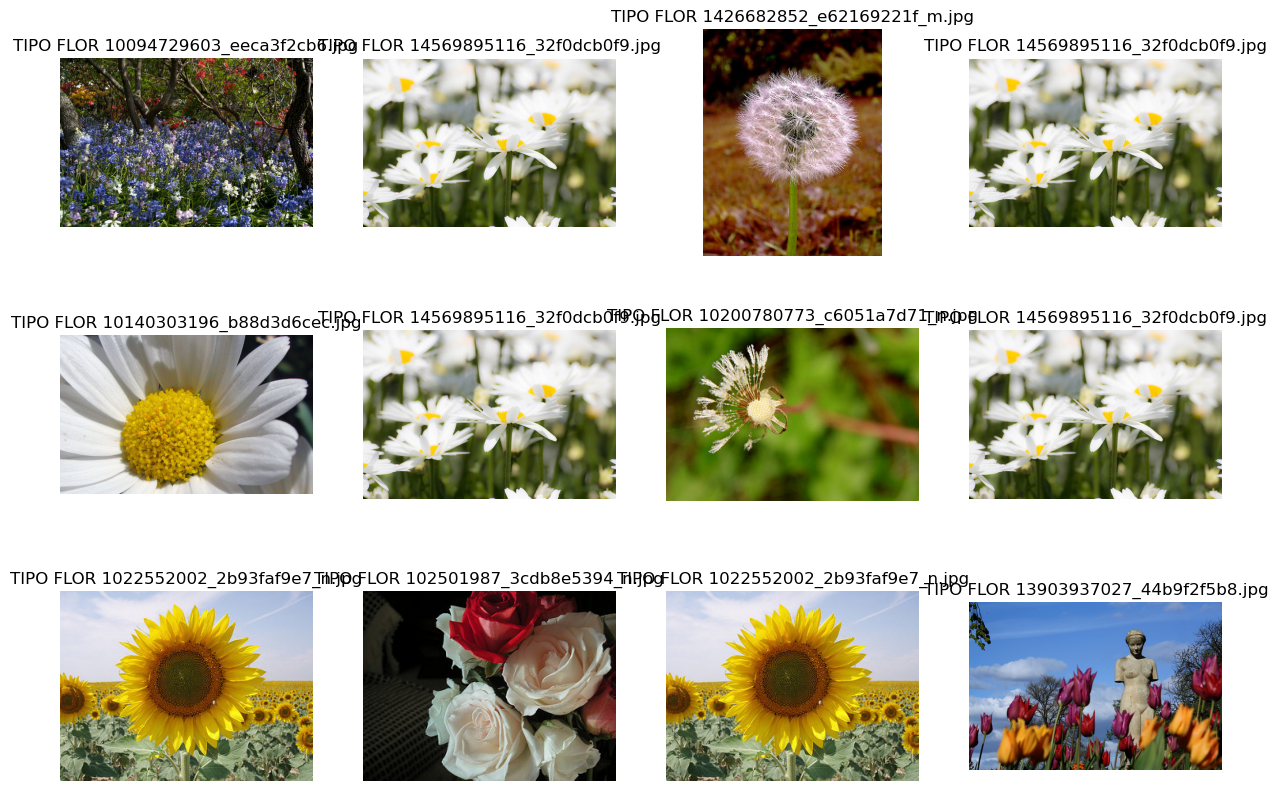

In [17]:
plt.figure(figsize=(15,10))
for i in range(12):
    ran = random.choice((1,100))
    rand_daisy = [os.path.join(ruta_ent_daisy, f) for f in train_dir_daisy[ran:ran+1]]
    rand_dandelion = [os.path.join(ruta_ent_dandelion, f) for f in train_dir_dandelion[ran:ran+1]]
    rand_roses = [os.path.join(ruta_ent_roses, f) for f in train_dir_roses[ran:ran+1]]
    rand_sunflowers = [os.path.join(ruta_ent_sunflowers, f) for f in train_dir_sunflowers[ran:ran+1]]
    rand_tulips = [os.path.join(ruta_ent_tulips, f) for f in train_dir_tulips[ran:ran+1]]
    rand = random.choice(rand_daisy+rand_dandelion+rand_roses+rand_sunflowers+rand_tulips)
    name = rand.split('/')
    name = 'TIPO FLOR ' + name[-1] 
    plt.subplot(3, 4, i+1)
    img = plt.imread(rand)
    plt.imshow(img,cmap = 'gray')
    plt.axis(False)
    plt.title(name)
plt.show()

Sample_Image_size(H*W): (150, 150, 3)


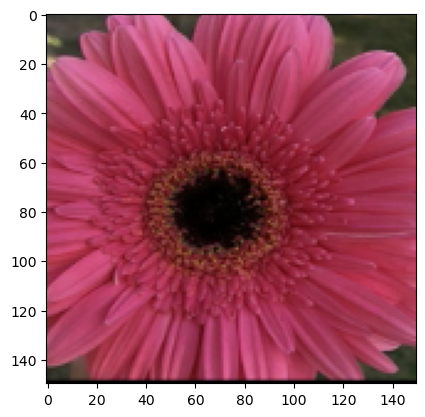

In [19]:
# Looking the size of a random sample image
sample = random.choice(train_dir_sunflowers)
sample = plt.imread(ruta_ent_sunflowers + sample)
samp = sample.shape
plt.imshow(sample)
print('Sample_Image_size(H*W):', samp)

In [52]:
# Metaparámetros del modelo de entrenamiento
batch_size = 1296
epochs = 30
verbose = 2
img_size = (32, 32)  # Tamaño de las imágenes ajustado a (32, 32)

# Metaparámetros del modelo de entrenamiento
INPUT_SHAPE = (32, 32, 3)
KERNEL_SIZE = (3, 3)
model = Sequential()

# Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)


In [53]:
#Considere las capas ya probadas
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_18 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_19 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                      

In [54]:

# Asegúrar que train_dir sea una cadena que apunte directamente al directorio de entrenamiento
train_dir = os.path.join(Path, 'flower_photos/train/')

classes = sorted(os.listdir(train_dir))

# Utilizar ImageDataGenerator para cargar imágenes desde el directorio y realizar aumentación de datos.
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    classes=classes,  # Lista de clases (subdirectorios)
    class_mode='categorical'  # o 'categorical' si hay más de dos clases
)


Found 15014 images belonging to 5 classes.


In [55]:
# Asegúrar que train_dir sea una cadena que apunte directamente al directorio de entrenamiento
val_dir = os.path.join(Path, 'flower_photos/val/')

# Obtén la lista de clases (subdirectorios) en el directorio de entrenamiento
classes = sorted(os.listdir(val_dir))

# Utilizar ImageDataGenerator para cargar imágenes desde el directorio y realizar aumentación de datos.
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    classes=classes,  # Lista de clases (subdirectorios)
    class_mode='categorical'  # o 'categorical' si hay más de dos clases
)
val_generator.class_indices

Found 9716 images belonging to 5 classes.


{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [56]:
# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=13,
    verbose=verbose
)
    

Epoch 1/30
11/11 - 89s - loss: 2.3465 - accuracy: 0.3832 - precision: 0.4324 - recall: 0.2613 - val_loss: 1.6058 - val_accuracy: 0.2235 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 89s/epoch - 8s/step
Epoch 2/30
11/11 - 60s - loss: 1.0993 - accuracy: 0.5589 - precision: 0.7369 - recall: 0.3362 - 60s/epoch - 5s/step
Epoch 3/30
11/11 - 71s - loss: 0.8884 - accuracy: 0.6609 - precision: 0.7878 - recall: 0.5147 - 71s/epoch - 6s/step
Epoch 4/30
11/11 - 70s - loss: 0.7245 - accuracy: 0.7338 - precision: 0.8320 - recall: 0.6346 - 70s/epoch - 6s/step
Epoch 5/30
11/11 - 70s - loss: 0.5906 - accuracy: 0.7943 - precision: 0.8707 - recall: 0.7180 - 70s/epoch - 6s/step
Epoch 6/30
11/11 - 59s - loss: 0.5055 - accuracy: 0.8293 - precision: 0.8892 - recall: 0.7710 - 59s/epoch - 5s/step
Epoch 7/30
11/11 - 68s - loss: 0.4463 - accuracy: 0.8518 - precision: 0.9034 - recall: 0.8027 - 68s/epoch - 6s/step
Epoch 8/30
11/11 - 71s - loss: 0.4003 - accuracy: 0.8686 - precision: 0.9146 - recall: 0.8249

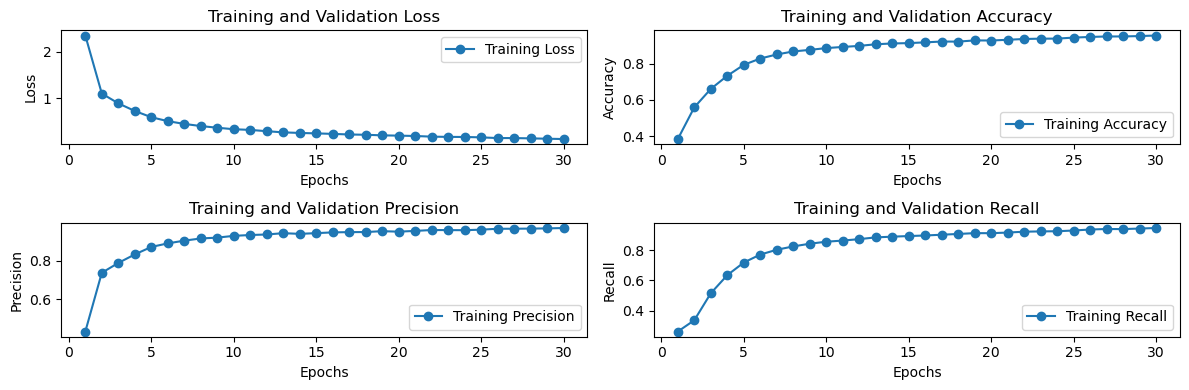

In [68]:
# Elaborar la gráfica de la pérdida y la exactitud del modelo entrenado
plt.figure(figsize=(12, 4))

# Gráfica de pérdida
plt.subplot(2, 2, 1)
plt.plot(range(1, 31), history.history['loss'], label='Training Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráfica de exactitud
plt.subplot(2, 2, 2)
plt.plot(range(1, 31), history.history['accuracy'], label='Training Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)
plt.plot(range(1, 31), history.history['precision'], label='Training Precision', marker='o')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)
plt.plot(range(1, 31), history.history['recall'], label='Training Recall', marker='o')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
   # 11/1 1: Indica que estás en la undécima iteración (batch) de la undécima época. Durante el entrenamiento, los datos se dividen en lotes (batches) para facilitar el proceso de optimización. En este caso, parece que estás utilizando 11 lotes por época.

    #- 65s: Indica que la duración del entrenamiento hasta este punto es de 65 segundos. Esto te da una idea del tiempo que ha transcurrido durante el entrenamiento de la época actual.

    #- loss: 0.1210: Muestra el valor actual de la función de pérdida en tu conjunto de entrenamiento. Este valor es una medida de cuánto se desvían las predicciones de tu modelo de los valores reales. En este caso, la pérdida es 0.1210, lo que generalmente es bastante bajo y sugiere que el modelo está haciendo buenas predicciones.

    #- accuracy: 0.9568: Representa la precisión del modelo en el conjunto de entrenamiento. En este caso, es 0.9568, lo que indica que aproximadamente el 95.68% de las predicciones del modelo son correctas.

    #- precision: 0.9688: Indica la precisión del modelo. La precisión es una métrica que mide la proporción de instancias positivas correctamente clasificadas entre todas las instancias clasificadas como positivas. En este caso, la precisión es 0.9688, lo que sugiere un alto nivel de precisión.

    #- recall: 0.9466: Representa el recall (o sensibilidad) del modelo. El recall mide la proporción de instancias positivas correctamente clasificadas entre todas las instancias que son realmente positivas. En este caso, el recall es 0.9466, indicando un buen rendimiento en la identificación de instancias positivas.

    #- 65s/epoch: Muestra el tiempo total que ha tomado entrenar hasta la época actual. En este caso, ha tomado 65 segundos para completar la época actual.

    #- 6s/step: Indica el tiempo promedio que ha tomado procesar cada lote (step) durante esta época. En este caso, cada lote ha tomado un promedio de 6 segundos para procesarse.

In [16]:
import os
import cv2
import numpy as np
from keras.models import load_model

# Cargar el modelo desde el archivo h5py
modelo = load_model('modelo.h5')

# Definir el diccionario de mapeo de clase (reemplaza esto con tus propias clases)
diccionario_clases = {
    0: 'daisy',
    1: 'dandelion',
    2: 'roses',
    3: 'sunflowers',
    4: 'tulips'
    # Agrega más clases según sea necesario
}

# Ruta de la carpeta que contiene las imágenes
carpeta_imagenes = 'flower_photos/pred'  # Cambia la ruta según tu estructura de carpetas

# Lista para almacenar las rutas de todas las imágenes en la carpeta
rutas_imagenes = []

# Enumerar todos los archivos en la carpeta
for nombre_archivo in os.listdir(carpeta_imagenes):
    ruta_imagen = os.path.join(carpeta_imagenes, nombre_archivo)
    # Verificar si es un archivo y tiene una extensión de imagen
    if os.path.isfile(ruta_imagen) and nombre_archivo.lower().endswith(('.png', '.jpg', '.jpeg')):
        rutas_imagenes.append(ruta_imagen)

def cargar_y_preprocesar_imagen(ruta):
    try:
        # Intenta cargar la imagen
        imagen = cv2.imread(ruta)
        if imagen is None:
            print(f"Error al cargar la imagen: {ruta}")
            return None

        # Verifica si la imagen tiene un tamaño válido antes de redimensionar
        if imagen.shape[0] == 0 or imagen.shape[1] == 0:
            print(f"Error: La imagen tiene un tamaño no válido: {ruta}")
            return None

        # Redimensiona la imagen a (32, 32)
        imagen = cv2.resize(imagen, (32, 32))

        # Preprocesamiento adicional según las necesidades del modelo (normalización, etc.)
        imagen = imagen / 255.0  # Normalización (suponiendo que se normalizaron durante el entrenamiento)
        return np.expand_dims(imagen, axis=0)  # Añade una dimensión adicional para el lote
    except Exception as e:
        print(f"Error desconocido al procesar la imagen: {ruta}. Detalles: {str(e)}")
        return None

# Cargar y preprocesar todas las imágenes
imagenes = [cargar_y_preprocesar_imagen(ruta) for ruta in rutas_imagenes]

# Filtrar imágenes que no pudieron cargarse o redimensionarse correctamente
imagenes = [img for img in imagenes if img is not None]

# Realizar predicciones para cada imagen
predicciones = [modelo.predict(img) for img in imagenes]

# Decodificar las predicciones y mostrar las rutas de las imágenes y las clases predichas
for ruta, prediccion in zip(rutas_imagenes, predicciones):
    clase_predicha = np.argmax(prediccion)
    nombre_clase_predicha = diccionario_clases.get(clase_predicha, 'Clase Desconocida')
    print(f'Imagen: {ruta}, Clase Predicha: {nombre_clase_predicha}')




1/1 [==============================] - 0s 42ms/step
Imagen: flower_photos/pred\choose-your-quantity-of-roses-globalrose.png, Clase Predicha: dandelion
Imagen: flower_photos/pred\images.jpg, Clase Predicha: dandelion
Imagen: flower_photos/pred\shutterstock_106387409.jpg, Clase Predicha: dandelion
Imagen: flower_photos/pred\sunflower-field.jpg, Clase Predicha: dandelion
